# (28) Lesion -- cNVAE

**Motivation**: Reproduce, it should segment. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Load model

In [2]:
mod_name = 'fixate1_z-14x[5,10,20]_k-32_d-17_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'ep500-b1200-lr(0.002)_beta(0.1:0x0.3)_lamb(0.01)_gr(250.0)_(2024_02_24,22:42)'

tr, metadata = load_model(
    model_name=mod_name,
    fit_name=fit_name,
    verbose=True,
    device='cuda',
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  39.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  22.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  3.0 Mil   |
| dec_sampler  |  3.0 Mil   |
|    expand    |  287.1 K   |
|  dec_tower   |  10.3 Mil  |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 39.3 M

In [3]:
print(f"{tr.cfg.name()}\n{tr.model.cfg.name()}")

ep500-b1200-lr(0.002)_beta(0.1:0x0.3)_lamb(0.01)_gr(250.0)
fixate1_z-14x[5,10,20]_k-32_d-17_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)

### Xtract

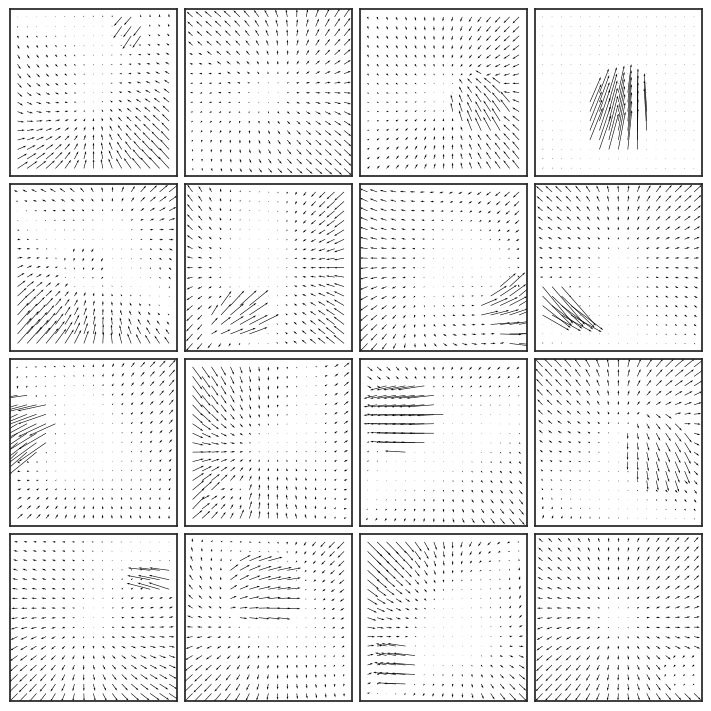

In [4]:
x, _ = next(iter(tr.dl_tst))
x = x[:16]

show_opticflow(x);

In [6]:
%%time

z, ftr, y, q, p = tr.model.xtract_ftr(x)
x.shape, y.shape, len(z)

CPU times: user 179 ms, sys: 297 µs, total: 179 ms
Wall time: 178 ms


(torch.Size([16, 2, 17, 17]), torch.Size([16, 2, 17, 17]), 35)

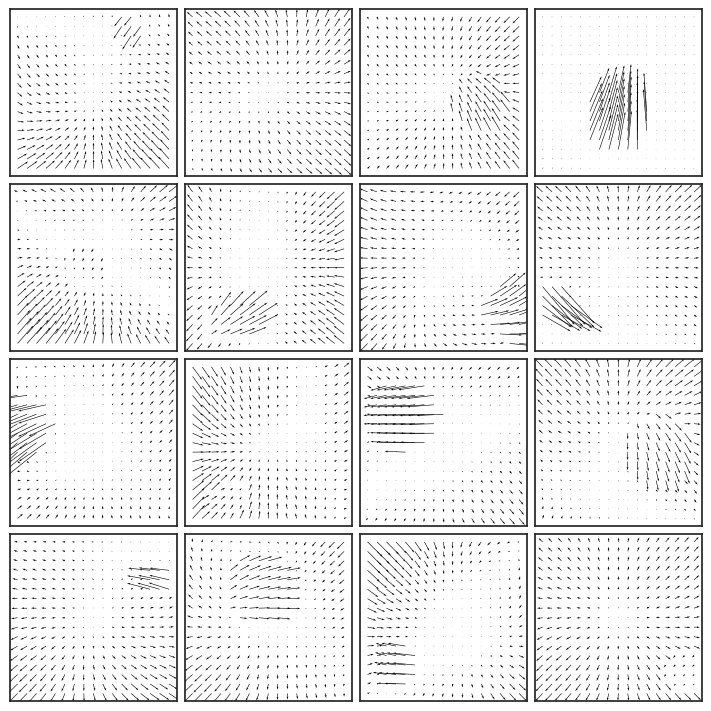

In [7]:
show_opticflow(y);

## Lesion

In [8]:
scales, _ = tr.model.latent_scales()
collections.Counter(scales), len(scales)

(Counter({2: 5, 4: 10, 8: 20}), 35)

In [9]:
lesion = {
    s: [s == item for item in scales]
    for s in np.unique(scales)
}

In [10]:
%%time

results_enc, results_z = {}, {}
for k, v in lesion.items():
    results_enc[k] = tr.model.xtract_ftr(
        x=x, lesion_enc=v)[2]
    results_z[k] = tr.model.xtract_ftr(
        x=x, lesion=v)[2]

CPU times: user 910 ms, sys: 23.1 ms, total: 933 ms
Wall time: 934 ms


### Plot: enc lesion

In [11]:
results2plot = torch.stack([x] + list(results_enc.values()))
results2plot.shape

torch.Size([4, 16, 2, 17, 17])

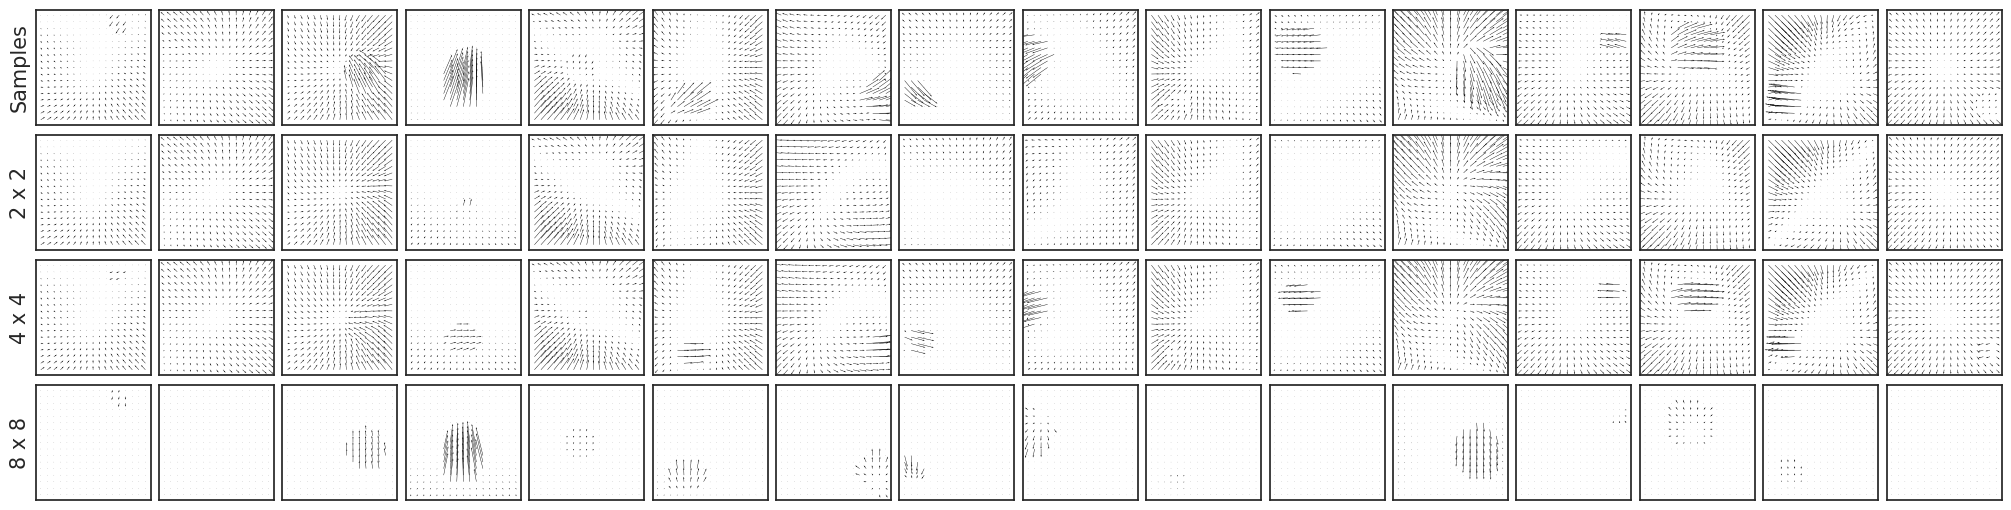

In [12]:
fig, axes = show_opticflow_row(results2plot, figsize=(20, 5), scale=5, display=False)

axes[0, 0].set_ylabel('Samples', fontsize=15)
for i, s in enumerate(lesion, start=1):
    axes[i, 0].set_ylabel(f'{s} x {s}', fontsize=15)

display(fig)

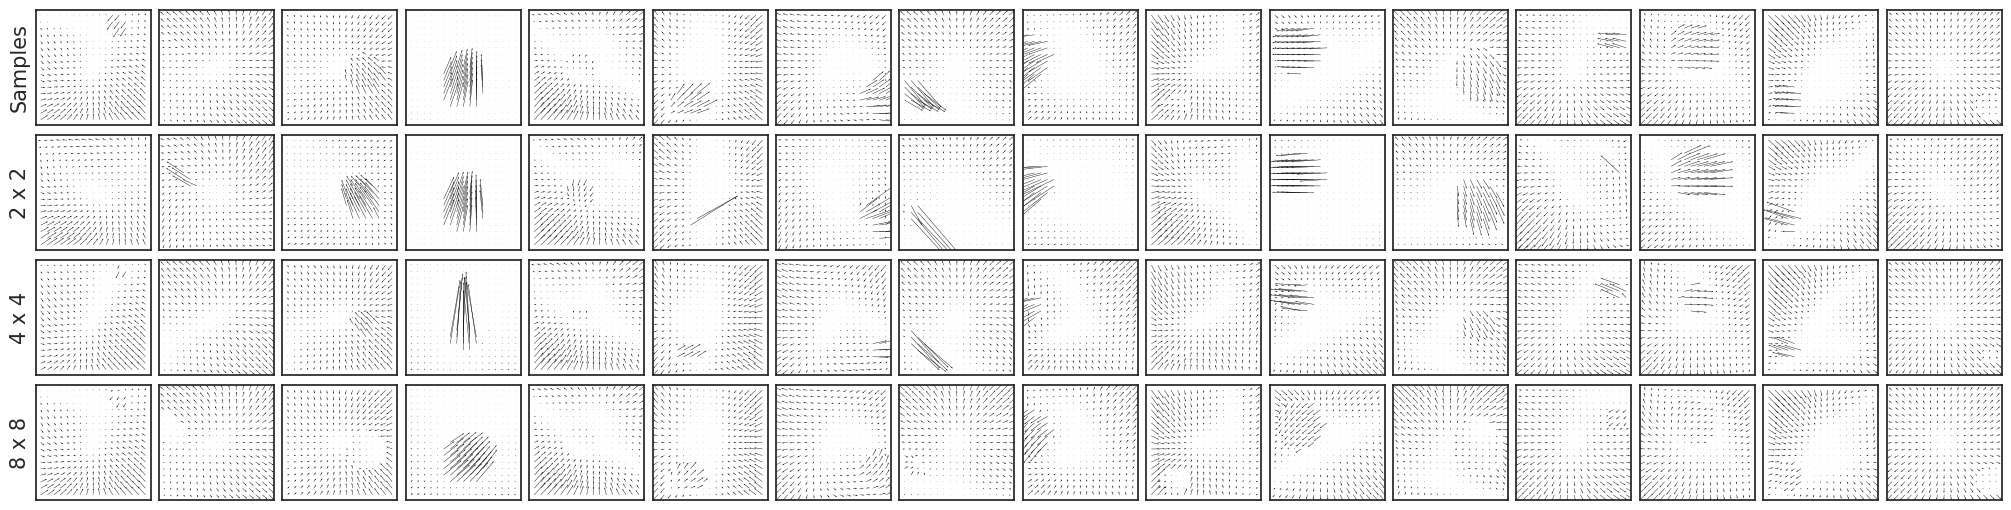

In [103]:
### was NVAE ###

### Plot: z lesion

In [13]:
results2plot = torch.stack([x] + list(results_z.values()))
results2plot.shape

torch.Size([4, 16, 2, 17, 17])

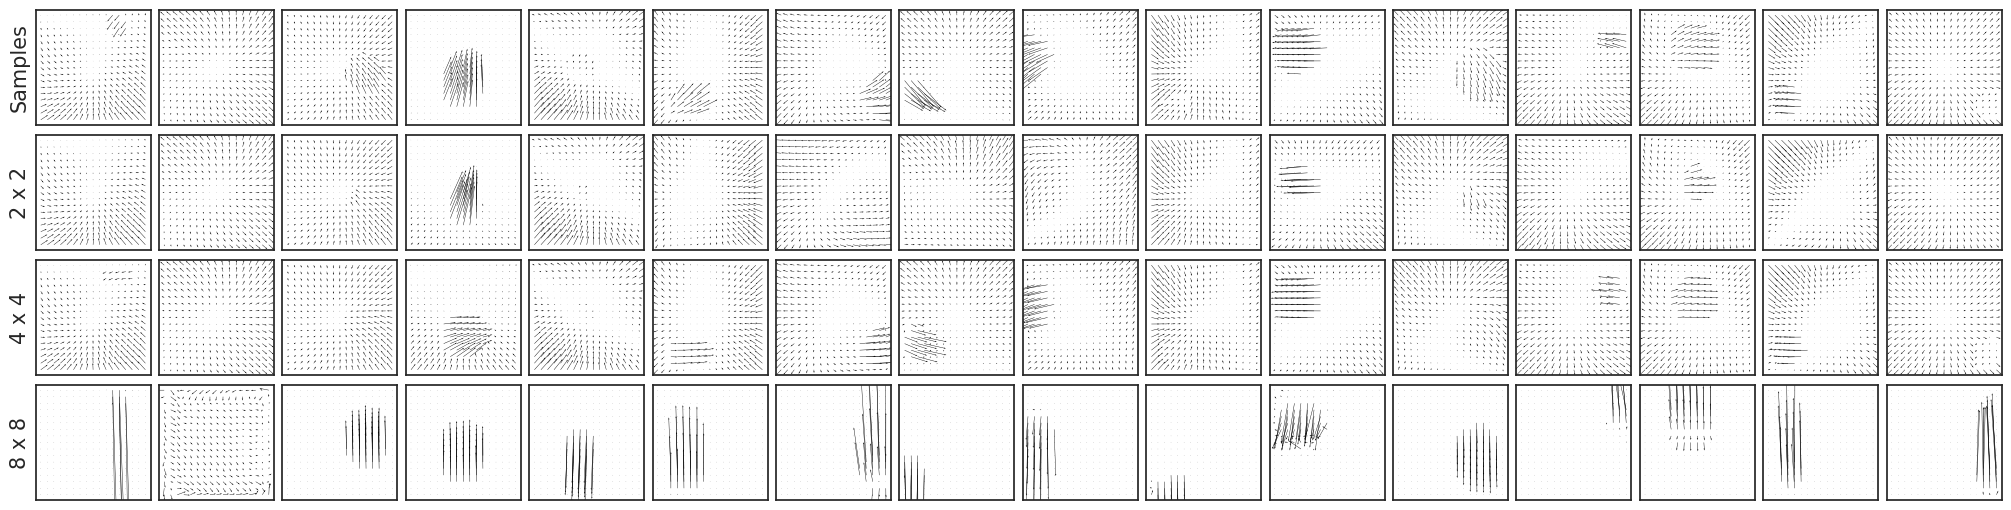

In [14]:
fig, axes = show_opticflow_row(results2plot, figsize=(20, 5), display=False)

axes[0, 0].set_ylabel('Samples', fontsize=15)
for i, s in enumerate(lesion, start=1):
    axes[i, 0].set_ylabel(f'{s} x {s}', fontsize=15)

display(fig)

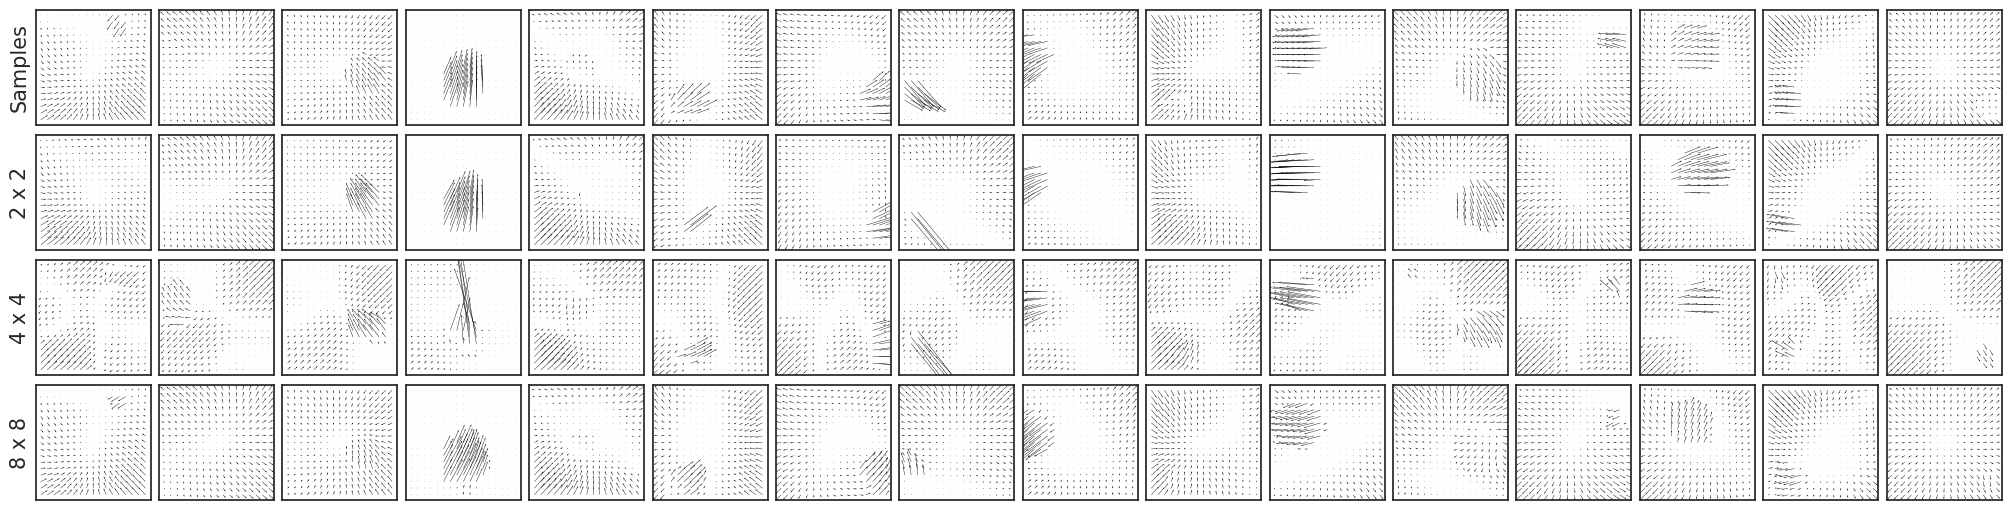

In [105]:
### was NVAE ###

## Plot enc_sampler weights

In [32]:
w2p = tr.model.enc_sampler[25].conv.weight.data
w2p.shape

torch.Size([28, 64, 8, 8])

In [33]:
norms = torch.norm(w2p, dim=(2, 3))
norms = to_np(norms)
norms.shape

(28, 64)

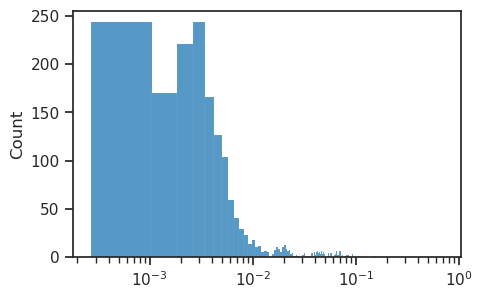

In [34]:
fig, ax = create_figure()
sns.histplot(norms.ravel(), ax=ax)
ax.set_xscale('log')
plt.show()

In [35]:
ids = np.argsort(norms.ravel())[::-1]
ids[:10]

array([ 337,  365,  372,  338,  368,  336,  350, 1245, 1219,  380])

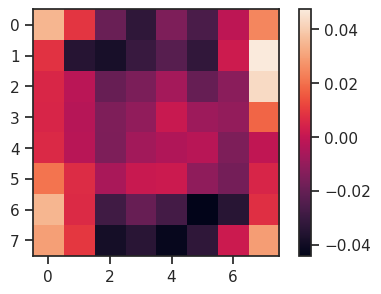

In [54]:
x2p = to_np(w2p[np.unravel_index(ids[18], norms.shape)])
plt.imshow(x2p)
plt.colorbar()
plt.show()

## Validate

In [55]:
val, loss = tr.validate()

In [57]:
loss['epe'].mean()

1.3025327

fig/sample

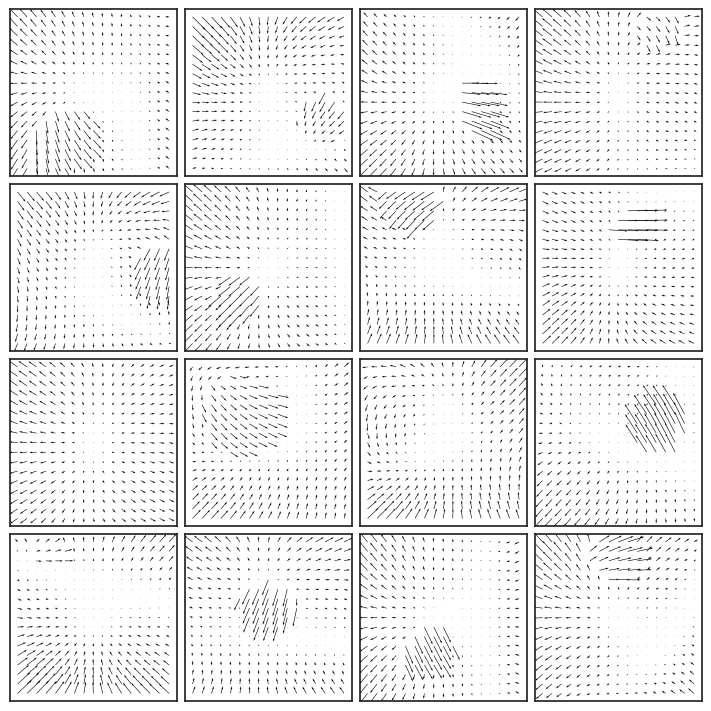

fig/regression

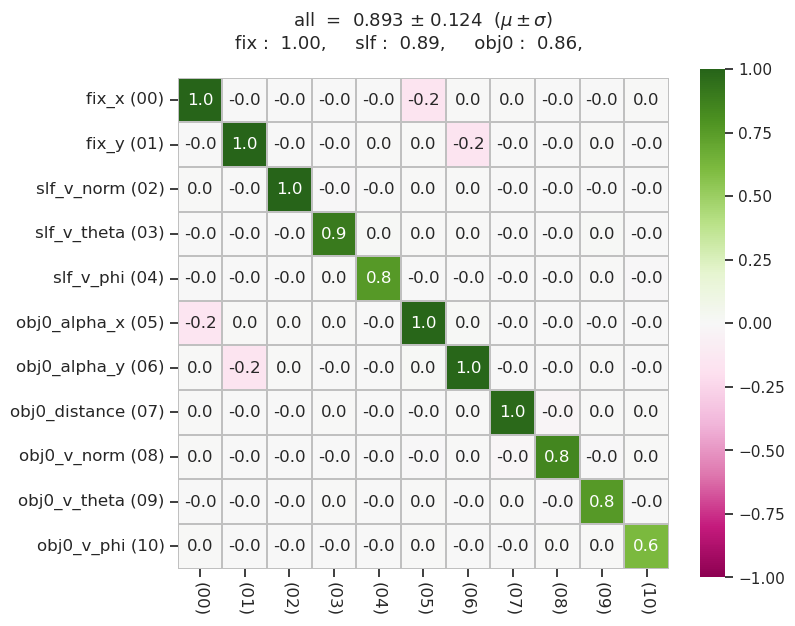

fig/bar

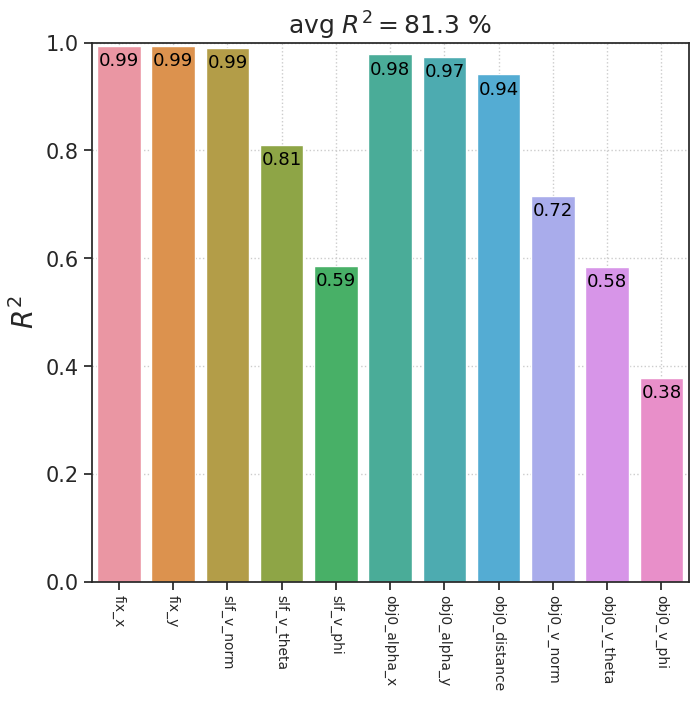

fig/bar_aux

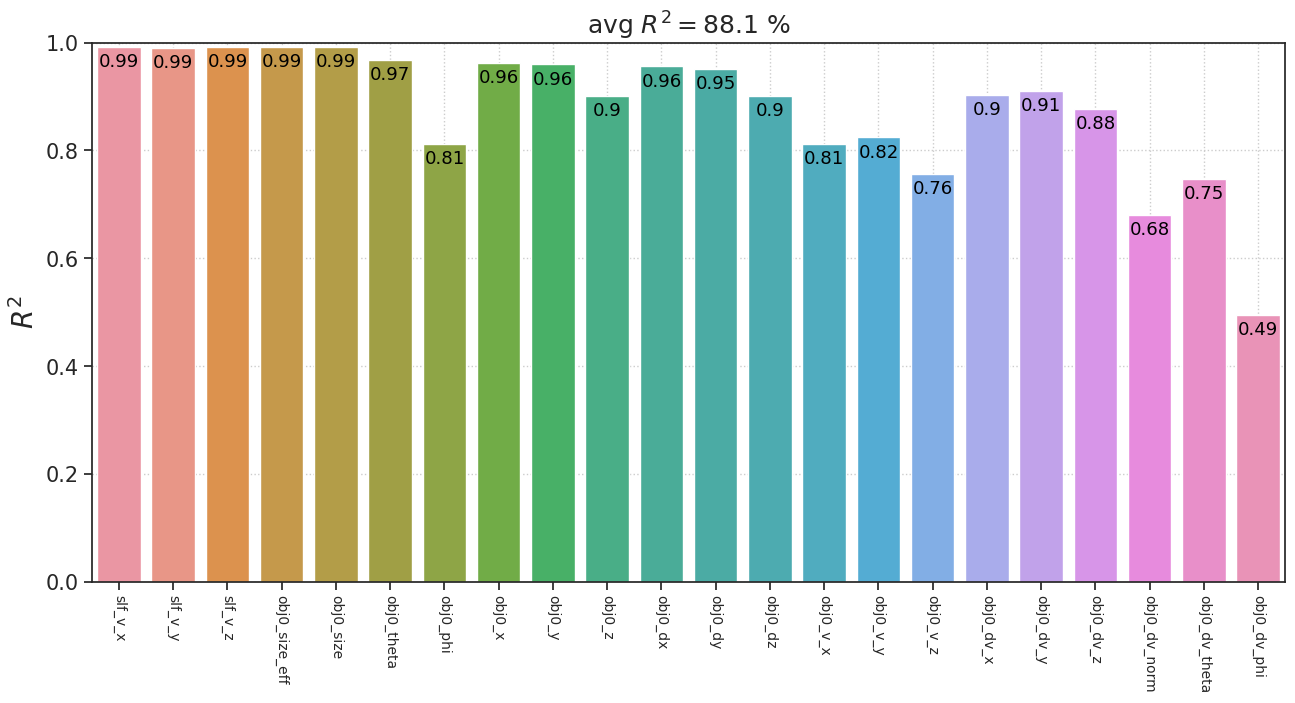

fig/mutual_info

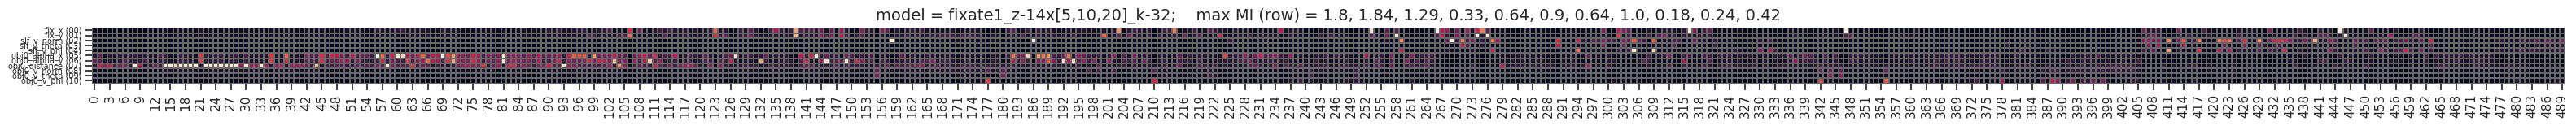

In [60]:
for k, v in val.items():
    if 'fig' in k:
        print(k)
        display(v)

In [64]:
np.argmax(val['regr/mi'], axis=1)

array([266, 258, 186, 290, 305,  69,  81,  22, 155, 346, 355])

## MEI

In [65]:
rng = get_rng()

In [66]:
def compute_mei(model, idx, start, alpha=0.1, nsteps=100, scalefunc=lambda x: 1, eps=1e-3, name=''):
    """
        Find an MEI for a given model and neuron ids.

        -model: a pytorch model
        -cids: a list of neuron ids
        -start: the initial input
        -alpha: the learning rate
        -nsteps: the number of steps to run
        -scalefunc: scales the learning rate as a func of step
        -eps: the convergence threshold
        -name: name for printing
    """

    x = start.clone()
    assert len(x) == 1

    pbar = tqdm(range(nsteps))
    for i in pbar:
        model.zero_grad()
        x_copy = x.clone()

        # Get the current prediction
        _, z, q, p = model(x)

        mu = torch.concatenate([d.mu for d in q], dim=1)
        mu = mu[0, idx].squeeze()
        # z = flat_cat(z)
        # z = z[0, idx]

        # Get the gradient of output with respect to input
        g = torch.autograd.grad(mu, x, retain_graph=True)[0]
        g_norm = torch.norm(g)
        
        if g is None or g_norm == 0:
            print("No gradient at step", i)
            return None

        # Update tqdm description
        msg = f"||g|| = {g_norm:0.5f}"
        pbar.set_description(msg)

        # Update the input
        x = x_copy + scalefunc(i) * alpha * g
        
        # Terminate if converged
        if torch.abs(x - x_copy).max() < eps:
            print(name, "converged at step", i)
            break

    return x

In [70]:
start = rng.normal(size=(1, 2, 17, 17))
start = nn.Parameter(
    data=torch.tensor(start),
    requires_grad=True,
)
start = tr.to(start)

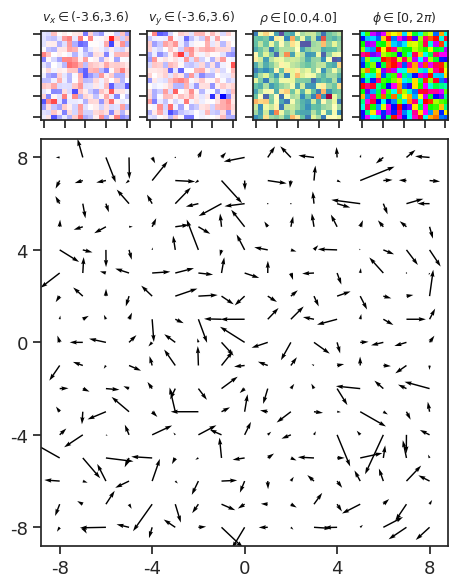

In [71]:
show_opticflow_full(start[0]);

In [72]:
%%time

mei = compute_mei(
    model=tr.model,
    idx=69,
    start=start,
    nsteps=10000,
    alpha=0.1,
)

||g|| = 0.09224: 100%|████████████████████| 10000/10000 [51:36<00:00,  3.23it/s]

CPU times: user 51min 37s, sys: 6.51 s, total: 51min 44s
Wall time: 51min 36s


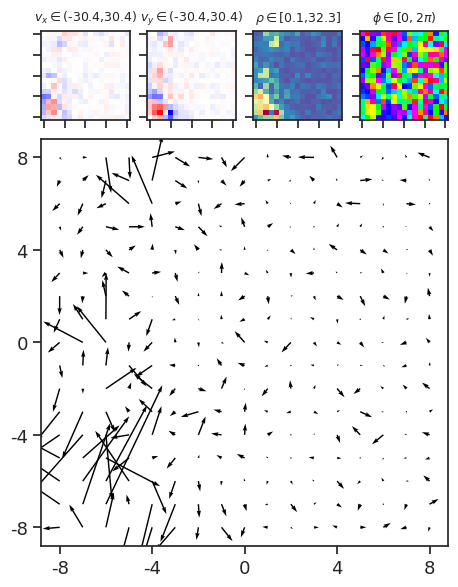

In [73]:
show_opticflow_full(mei[0]);

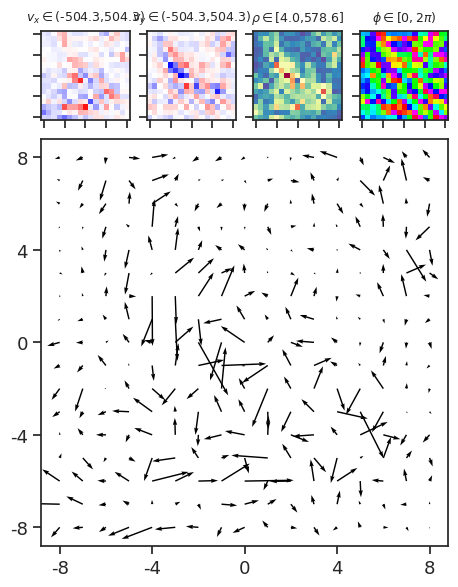

In [74]:
%%time

mei = compute_mei(
    model=tr.model,
    idx=155,
    start=start,
    nsteps=10000,
    alpha=0.1,
)

||g|| = 10.49000: 100%|███████████████████| 10000/10000 [47:48<00:00,  3.49it/s]

CPU times: user 47min 50s, sys: 5.84 s, total: 47min 56s
Wall time: 47min 48s


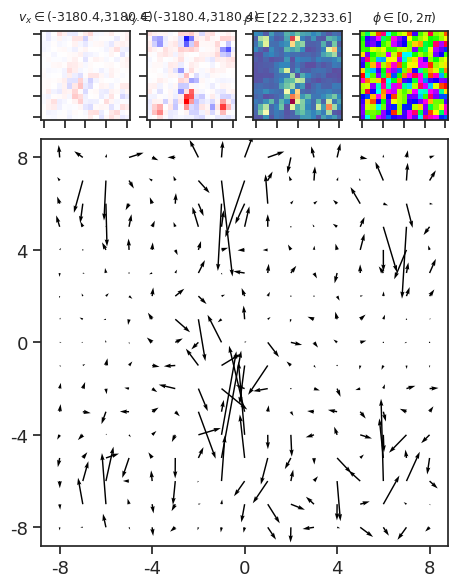

In [75]:
show_opticflow_full(mei[0]);

## GLM on latents

In [4]:
%%time

kws = dict(freeze=True, use_ema=False)
z_vld = tr.forward('vld', **kws)[0]['z']
z_tst = tr.forward('tst', **kws)[0]['z']

CPU times: user 2h 14min 52s, sys: 4min 2s, total: 2h 18min 54s
Wall time: 5min 22s


In [5]:
x_vld = to_np(tr.dl_vld.dataset.x)
x_tst = to_np(tr.dl_tst.dataset.x)

In [6]:
from sklearn.linear_model import Ridge

In [42]:
lr = Ridge(alpha=50000).fit(
    X=flatten_stim(x_vld),
    y=z_vld,
)

In [43]:
pred = lr.predict(flatten_stim(x_tst))

r2 = np.round(sk_metric.r2_score(
    y_true=z_tst,
    y_pred=pred,
    multioutput='raw_values',
) * 100)
r2.mean()

15.263265306122449

In [45]:
r = 1 - np.diag(sp_dist.cdist(
    XA=z_tst.T,
    XB=pred.T,
    metric='correlation',
))

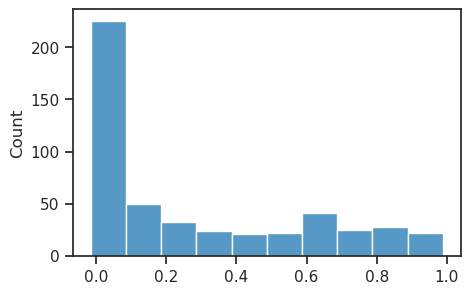

In [46]:
sns.histplot(r);

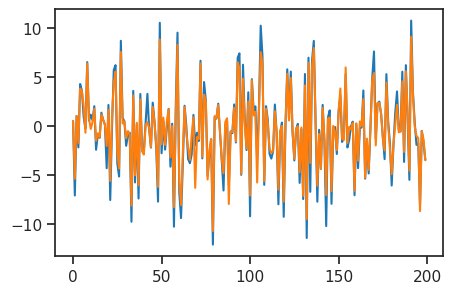

In [48]:
plt.plot(z_tst[1000:1200, ids[0]])
plt.plot(pred[1000:1200, ids[0]])

In [49]:
sp_stats.pearsonr(r, r2)

(0.946963175982596, 9.577956237406823e-243)

In [50]:
ids = np.argsort(r2)[::-1]
ids[:5]

array([454, 302, 264, 422, 421])

In [51]:
kers = lr.coef_.reshape(-1, *x_vld.shape[1:])
kers.shape

(490, 2, 17, 17)

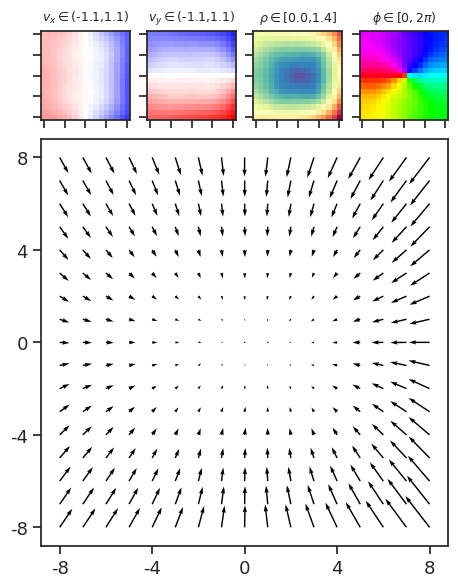

In [77]:
show_opticflow_full(kers[ids[1]]);

In [78]:
ids[0]

454